<a href="https://colab.research.google.com/github/SydanJainen/4EU-DeepLearningCourse/blob/main/Assignments/AssignementCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignments

### We are given a dataset containing 510 images which are categorized according two main characteristics/properties: “C1” and “C2”. The following inputs are available:
* #### `input image', a 110 × 110 × 3 real-valued tensor. The last dimension denotes the number of input channels; the images belong to different combinations of the two properties C1 and C2. For C1 and C2 we have 5 and 6 possible values, respectively;  among the 30 possible couples (C1,C2), we have images for only 24 of them. We have around 20 samples (little more or less) for each of the available couples;  values in each tensor entry are integers in [0, 255];
* #### C1, string, the value for the C1 property. 5 possible values;
* #### C2, string, the value for the C2 property. 6 possible values.

### Design a deep neural network model to predict the class of an image, given by the couple (C1,C2).

### Provide a sketch of each of the following points, then implement your solution.
1. MODEL: Which architecture do you consider the most appropriate for this task, and why;
2. INPUT:
* After a potential preprocessing step, which is the input of the model, and
how is it represented;
3. OUTPUT: How would you design the output layer and why;
4. LOSS: Which loss function would you use to train your model and why;
5. MODEL CONFIGURATION:
 Model composition (composition of layers, regardless their number,
or their dimension, which can be object of tuning)
6. MODEL EVALUATION: How would you assess (in which setting) the
generalization capabilities of the model on unseen data?


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

## go to your datapath
%cd /content/drive/MyDrive/INSEGNAMENTI/4EU+/

# Here you should see the desired files
%ls

Mounted at /content/drive
/content/drive/MyDrive/INSEGNAMENTI/4EU+
input.pkl


In [5]:
import pickle as pk
# Open the pickle data
with open('input.pkl', 'rb') as f:
  data = pk.load(f)

images = data['imgs']
C1 = data['C1']
C2 = data['C2']
print(f"length image:{len(images)}")
print(f"length C1:{len(C1)}")
print(f"length C2:{len(C2)}")

length image:510
length C1:510
length C2:510


In [35]:
#import
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms


import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import random_split

In [36]:
transofm = Compose([ToTensor(),
                        Normalize((0,), (1,))])
tensor_images = []
for i in images :
  tensor_images.append(transofm(i))

In [37]:
for a in np.unique(C1):
  print(a)

dress
pants
shirt
shoes
shorts


In [38]:
for a in np.unique(C2):
  print(a)

black
blue
brown
green
red
white


In [39]:
main_dataset = zip(tensor_images, C1, C2)

label_combinations = {}
for i, (c1, c2) in enumerate(zip(C1, C2)):
    label_combinations[i] = f"{c1} {c2}"

unique_labels = set(label_combinations.values())
label_to_index = {label: i for i, label in enumerate(unique_labels)}
print(label_to_index)

enumerated_dataset = []
for i, (tensor_images, c1, c2) in enumerate(zip(tensor_images, C1, C2)):
  label_combination = f"{c1} {c2}"
  label_index = label_to_index[label_combination]
  enumerated_dataset.append((tensor_images, label_index))

print(len(enumerated_dataset))

{'shoes green': 0, 'dress black': 1, 'shorts white': 2, 'shoes red': 3, 'shoes white': 4, 'pants red': 5, 'shorts black': 6, 'shorts brown': 7, 'pants black': 8, 'dress white': 9, 'shoes blue': 10, 'shorts blue': 11, 'shoes black': 12, 'pants green': 13, 'shorts green': 14, 'shirt green': 15, 'dress red': 16, 'pants brown': 17, 'shoes brown': 18, 'pants white': 19, 'shirt black': 20, 'dress blue': 21, 'pants blue': 22, 'shirt blue': 23}
510


In [40]:
BATCH_SIZE = 20

train_size = int(0.6 * len(enumerated_dataset))
val_size = int(0.2 * len(enumerated_dataset))
test_size = len(enumerated_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(enumerated_dataset, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [41]:
def dimension(N,P,S,F) :
  return (int((N + (2*P) - F)/ S) + 1)

In [42]:
print(dimension(108, 0, 1, 3))

106


In [45]:
# model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=32,
                               kernel_size = 3,
                               stride=1,
                               padding=0)
        #  feature map dim 108x108x32
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        # dim 106 x 106 x 64
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # dim 53 x 53 x 64, 'same' = 2.809
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(179776, 128)
        self.dropout2 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 24)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

#Creating the model
model = CNN()
print(model)

# calling the method on one batch
it = iter(train_loader)
X_batch, Y_batch = next(it)


# Computing the accuracy of a test set
def evaluate(model, test_loader, error):
#model = mlpinplace=False
    correct = 0
    cur_loss = 0;

    for test_imgs, test_labels in test_loader:
        test_imgs, test_labels = test_imgs.cuda(), test_labels.cuda()
        output = model(test_imgs)
        loss = error(output, test_labels)
        cur_loss+=loss.item()
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    return cur_loss/len(test_loader.dataset), correct/len(test_loader.dataset)



#training the model
def fit(model, train_loader, error, test_loader, epochs):
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)


    model.train()
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        cur_loss = 0;
        correct = 0
        for X_batch, y_batch in train_loader:
            # moving data to GPU
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            optimizer.zero_grad()
            output = model(X_batch)
            loss = error(output, y_batch)
            cur_loss+= loss.item()
            loss.backward()
            optimizer.step()

        train_losses.append(cur_loss/len(train_loader.dataset))

        test_loss, _ = evaluate(model, test_loader, error)
        test_losses.append(test_loss)
        print(f'Epoch : {epoch},  train loss:{train_losses[-1]}, test loss:{test_losses[-1]}')

    return train_losses, test_losses

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=179776, out_features=128, bias=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=24, bias=True)
)


cuda:0
Epoch : 0,  train loss:0.1684774339588639, test loss:0.18242801871954226
Epoch : 1,  train loss:0.15897495294708053, test loss:0.17789297010384353
Epoch : 2,  train loss:0.15047556278752347, test loss:0.17105510421827727
Epoch : 3,  train loss:0.1405071892769508, test loss:0.16026046696831198
Epoch : 4,  train loss:0.13173076763651728, test loss:0.15951596288120046
Epoch : 5,  train loss:0.12075320139429928, test loss:0.1505807170680925
Epoch : 6,  train loss:0.10619276917837804, test loss:0.1458947354672002
Epoch : 7,  train loss:0.09666370800118042, test loss:0.12490578959969913
Epoch : 8,  train loss:0.08779177361843633, test loss:0.13237977962867886
Epoch : 9,  train loss:0.07903018223693947, test loss:0.1369189000597187
Epoch : 10,  train loss:0.0717370778906579, test loss:0.1213174953180201
Epoch : 11,  train loss:0.05862655261762781, test loss:0.12321814135009167
Epoch : 12,  train loss:0.05427476315716513, test loss:0.1234746026057823
Epoch : 13,  train loss:0.0458941102

<Figure size 640x480 with 0 Axes>

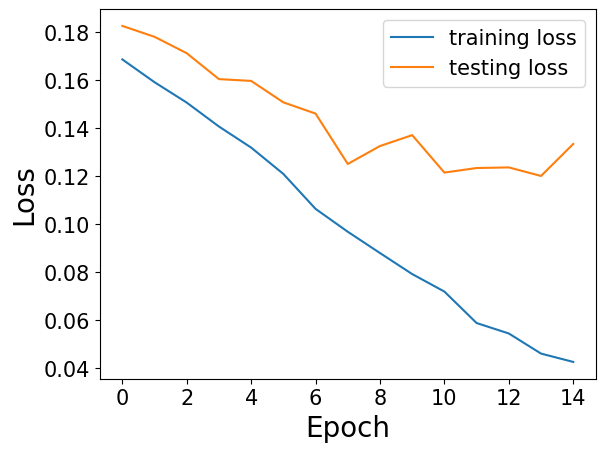

<Figure size 640x480 with 0 Axes>

In [46]:
# train
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
print(dev)
device = torch.device(dev)
model.cuda()

epochs = 15
error = nn.CrossEntropyLoss()
train_losses, test_losses = fit(model,train_loader, error, test_loader, epochs)

plt.plot(train_losses,label="training loss")
plt.plot(test_losses,label="testing loss")
plt.legend(fontsize=15)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure()

In [47]:
# validate and test

loss, acc = evaluate(model, train_loader, error)
print(f"Train Accuracy:{acc}, Train loss:{loss}")

loss, acc = evaluate(model, test_loader, error)
print(f"Test Accuracy:{acc}, Test loss:{loss}")

loss, acc = evaluate(model, val_loader, error)
print(f"Validation Accuracy:{acc}, Validation loss:{loss}")

Train Accuracy:0.826797366142273, Train loss:0.038558462184239056
Test Accuracy:0.3921568691730499, Test loss:0.11341571340373918
Validation Accuracy:0.29411765933036804, Validation loss:0.14008435548520556
